In [2]:
import numpy as np
from scipy import stats
from scipy.optimize import minimize, NonlinearConstraint
import matplotlib.pyplot as plt

class InsuranceOptimizer:
    """Optimize insurance program with constraints."""

    def __init__(self, initial_wealth, growth_params, loss_dist):
        self.W0 = initial_wealth
        self.growth_params = growth_params
        self.loss_dist = loss_dist

    def objective(self, x):
        """Maximize expected log wealth (negative for minimization)."""
        retention, limit = x[0], x[1]

            # Simulate outcomes
        n_sims = 1000
        final_wealth = []

        for _ in range(n_sims):
            # Base growth
            growth = np.random.normal(
                self.growth_params['mu'],
                self.growth_params['sigma']
            )
            wealth = self.W0 * (1 + growth)

            # Loss and insurance
            loss = self.loss_dist.rvs()
            retained_loss = min(loss, retention)
            covered_loss = min(max(0, loss - retention), limit)

            # Premium (simplified)
            premium = 0.01 * limit + 0.02 * max(0, limit - retention)

            # Final wealth
            wealth = wealth - retained_loss - premium
            final_wealth.append(max(0, wealth))

        # Expected log utility
        positive_wealth = [w for w in final_wealth if w > 0]

        if not positive_wealth:
            return 1e10 # Penalize bankruptcy

        return -np.mean(np.log(positive_wealth))

    def ruin_constraint(self, x):
        """Probability of ruin constraint."""
        retention, limit = x[0], x[1]

        # Simulate ruin probability
        n_sims = 1000
        ruin_count = 0

        for _ in range(n_sims):
            wealth = self.W0
            for year in range(10):
                # 10-year horizon
                growth = np.random.normal(
                    self.growth_params['mu'],
                    self.growth_params['sigma']
                )
                wealth *= (1 + growth)

                loss = self.loss_dist.rvs()
                retained_loss = min(loss, retention)
                premium = 0.01 * limit + 0.02 * max(0, limit - retention)

                wealth = wealth - retained_loss - premium

                if wealth <= 0:
                    ruin_count += 1
                    break

        return ruin_count / n_sims  # Should be <= threshold

    def optimize(self, ruin_threshold=0.01, budget=None):
        """Find optimal insurance program."""

        # Initial guess
        x0 = [self.W0 * 0.05, self.W0 * 0.20]  # 5% retention, 20% limit

        # Bounds
        bounds = [
            (0, self.W0 * 0.10),  # Retention: 0 to 10% of wealth
            (0, self.W0 * 0.50)  # Limit: 0 to 50% of wealth
        ]

        # Constraints
        constraints = []

        # Ruin probability constraint
        constraints.append(NonlinearConstraint(
            self.ruin_constraint,
            lb=0,
            ub=ruin_threshold
        ))

        # Budget constraint if specified
        if budget:
            def premium_constraint(x):
                return 0.01 * x[1] + 0.02 * max(0, x[1] - x[0])

            constraints.append(NonlinearConstraint(
                premium_constraint,
                lb=0,
                ub=budget
            ))

        # Optimize
        result = minimize(
            self.objective,
            x0,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'maxiter': 100}
        )

        return result

# Example optimization
optimizer = InsuranceOptimizer(
    initial_wealth=10_000_000,
    growth_params={'mu': 0.08, 'sigma': 0.15},
    loss_dist=stats.lognorm(s=2, scale=100_000)
)

result = optimizer.optimize(ruin_threshold=0.01)

print(f"Optimal retention: ${result.x[0]:,.0f}")
print(f"Optimal limit: ${result.x[1]:,.0f}")
print(f"Expected growth: {-result.fun:.4f}")

Optimal retention: $500,078
Optimal limit: $1,997,977
Expected growth: 16.1570


C:\Users\alexf\AppData\Local\Temp\ipykernel_17388\1030751109.py:119: RuntimeWarning: invalid value encountered in divide
  obj_norm = (objectives - objectives.min(axis=0)) / (objectives.max(axis=0) - objectives.min(axis=0))


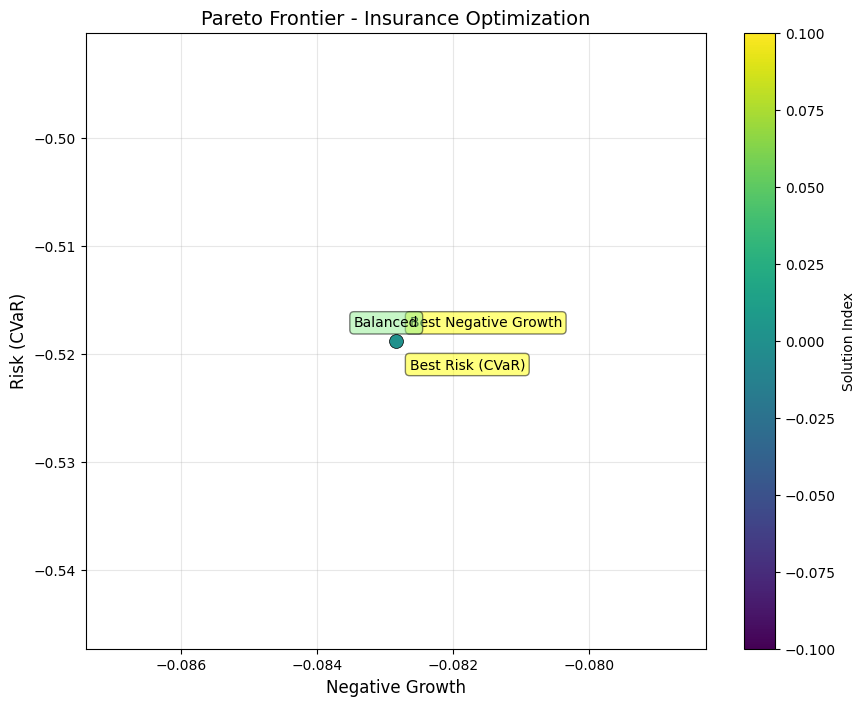

In [8]:
class ParetoFrontier:
    """Compute Pareto frontier for insurance decisions."""

    def __init__(self, objectives, constraints):
        self.objectives = objectives
        self.constraints = constraints

    def weighted_sum_method(self, weights_grid):
        """Generate Pareto frontier using weighted sum."""
        frontier = []

        for i, weights in enumerate(weights_grid):
            # Combined objective
            def combined_objective(x):
                return sum(w * obj(x) for w, obj in zip(weights, self.objectives))

            # Use varied starting points for diversity
            x0_retention = 0.1 + 0.8 * (i / len(weights_grid))
            x0_coverage = 0.9 - 0.7 * (i / len(weights_grid))

        # Optimize
        result = minimize(
            combined_objective,
            x0=[x0_retention, x0_coverage],  # Varied initial guess
            bounds=[(0, 1), (0, 2)],  # Extended bounds for coverage
            constraints=self.constraints,
            method='SLSQP'
        )

        if result.success:
            # Evaluate all objectives
            obj_values = [obj(result.x) for obj in self.objectives]
            frontier.append({
                'x': result.x,
                'objectives': obj_values,
                'weights': weights
            })

        return frontier

    def epsilon_constraint_method(self, epsilon_grid):
        """Generate Pareto frontier using epsilon-constraint."""
        frontier = []

        for eps in epsilon_grid:
            # Minimize first objective
            def primary_objective(x):
                return self.objectives[0](x)

            # Constrain other objectives
            additional_constraints = []
            for i, obj in enumerate(self.objectives[1:], 1):
                additional_constraints.append(NonlinearConstraint(obj, lb=-np.inf, ub=eps[i-1]))

            # Optimize
            all_constraints = self.constraints + additional_constraints

        result = minimize(
            primary_objective,
            x0=[0.5, 0.5],
            bounds=[(0, 1), (0, 1)],
            constraints=all_constraints,
            method='SLSQP'
        )

        if result.success:
            obj_values = [obj(result.x) for obj in self.objectives]
            frontier.append({
            'x': result.x,
            'objectives': obj_values,
            'epsilon': eps
        })

        return frontier

    def plot_frontier(self, frontier, obj_names=['Obj 1', 'Obj 2']):
        """Visualize Pareto frontier."""
        objectives = np.array([f['objectives'] for f in frontier])

        if objectives.shape[1] == 2:
            # 2D plot
            plt.figure(figsize=(10, 8))

            # Main scatter plot with gradient coloring
            scatter = plt.scatter(objectives[:, 0], objectives[:, 1],
            c=range(len(objectives)), cmap='viridis',
            s=100, edgecolors='black', linewidth=0.5)

            # Connect points with line
            sorted_idx = np.argsort(objectives[:, 0])
            plt.plot(objectives[sorted_idx, 0], objectives[sorted_idx, 1],
            'b-', alpha=0.3, linewidth=1)

            plt.xlabel(obj_names[0], fontsize=12)
            plt.ylabel(obj_names[1], fontsize=12)
            plt.title('Pareto Frontier - Insurance Optimization', fontsize=14)
            plt.grid(True, alpha=0.3)

            # Add colorbar
            cbar = plt.colorbar(scatter)
            cbar.set_label('Solution Index', fontsize=10)

            # Annotate extreme points
            min_obj1_idx = np.argmin(objectives[:, 0])
            min_obj2_idx = np.argmin(objectives[:, 1])

            plt.annotate(f'Best {obj_names[0]}',
            (objectives[min_obj1_idx, 0], objectives[min_obj1_idx, 1]),
            xytext=(10, 10), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

            plt.annotate(f'Best {obj_names[1]}',
            (objectives[min_obj2_idx, 0], objectives[min_obj2_idx, 1]),
            xytext=(10, -20), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

            # Find and annotate balanced solution
            # Normalize objectives and find closest to ideal
            obj_norm = (objectives - objectives.min(axis=0)) / (objectives.max(axis=0) - objectives.min(axis=0))
            distances = np.sqrt(obj_norm[:, 0]**2 + obj_norm[:, 1]**2)
            balanced_idx = np.argmin(distances)

            plt.annotate('Balanced',
            (objectives[balanced_idx, 0], objectives[balanced_idx, 1]),
            xytext=(-30, 10), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.5))

        elif objectives.shape[1] == 3:
            # 3D plot
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')
            scatter = ax.scatter(objectives[:, 0], objectives[:, 1], objectives[:, 2],
            c=range(len(objectives)), cmap='viridis', s=50)
            ax.set_xlabel(obj_names[0])
            ax.set_ylabel(obj_names[1])
            ax.set_zlabel(obj_names[2])
            ax.set_title('3D Pareto Frontier')
            plt.colorbar(scatter)

            plt.tight_layout()
            plt.show()

# Example: Growth vs Risk trade-off with better spread
def growth_objective(x):
    """Negative expected growth (for minimization) - improved model."""
    retention, coverage = x
    # More complex growth model with non-linear effects
    base_growth = 0.12
    growth_benefit = 0.03 * np.tanh(coverage / 2)
    # Diminishing returns
    retention_penalty = 0.08 * (retention ** 2)
    # Quadratic penalty
    premium_cost = 0.02 * coverage + 0.01 * max(0, coverage - retention)
    growth = base_growth + growth_benefit - retention_penalty - premium_cost
    return -growth
    # Negative for minimization

def risk_objective(x):
    """Risk measure (CVaR approximation) - improved model."""
    retention, coverage = x
        # Non-linear risk components
    retained_risk = 0.4 * (retention ** 1.5)
    risk_reduction = 0.6 * (1 - np.exp(-coverage))
    tail_risk = 0.3 * max(0, 1 - coverage) ** 2
    return retained_risk - risk_reduction + tail_risk

# Create Pareto frontier with relaxed constraints for better spread
objectives = [growth_objective, risk_objective]
constraints = [
    NonlinearConstraint(lambda x: x[0] + x[1], lb=0, ub=3.0)
    # Relaxed constraint
]

pareto = ParetoFrontier(objectives, constraints)

# Generate frontier with more diverse starting points
weights_grid = []
for i in range(30):
    # More points
    theta = (i / 29) * np.pi / 2
    w1 = np.cos(theta) ** 2
    w2 = np.sin(theta) ** 2
    weights_grid.append((w1, w2))

frontier = pareto.weighted_sum_method(weights_grid)

# Visualize
pareto.plot_frontier(frontier, ['Negative Growth', 'Risk (CVaR)'])

EXAMPLE 1: REINSURANCE OPTIMIZATION

1. WEIGHTED SUM METHOD
------------------------------
Found 20 Pareto-optimal solutions

Sample solutions (different risk appetites):

Conservative (80% loss, 20% cost weight):
  Retention: 0.00%
  Coverage: 0.00x
  Expected Loss: $0.0M
  Reinsurance Cost: $23.0M

Aggressive (20% loss, 80% cost weight):
  Retention: 100.00%
  Coverage: 0.00x
  Expected Loss: $100.0M
  Reinsurance Cost: $11.5M

2. EPSILON-CONSTRAINT METHOD
------------------------------
Found 15 Pareto-optimal solutions

Solutions at different cost constraints:

Cost limit: $15.0M
  Retention: 69.57%
  Coverage: 0.00x
  Expected Loss: $64.7M
  Actual Cost: $15.0M

Cost limit: $27.5M
  Retention: 0.00%
  Coverage: 0.16x
  Expected Loss: $0.0M
  Actual Cost: $26.0M

Cost limit: $40.0M
  Retention: 0.00%
  Coverage: 0.92x
  Expected Loss: $0.0M
  Actual Cost: $40.0M


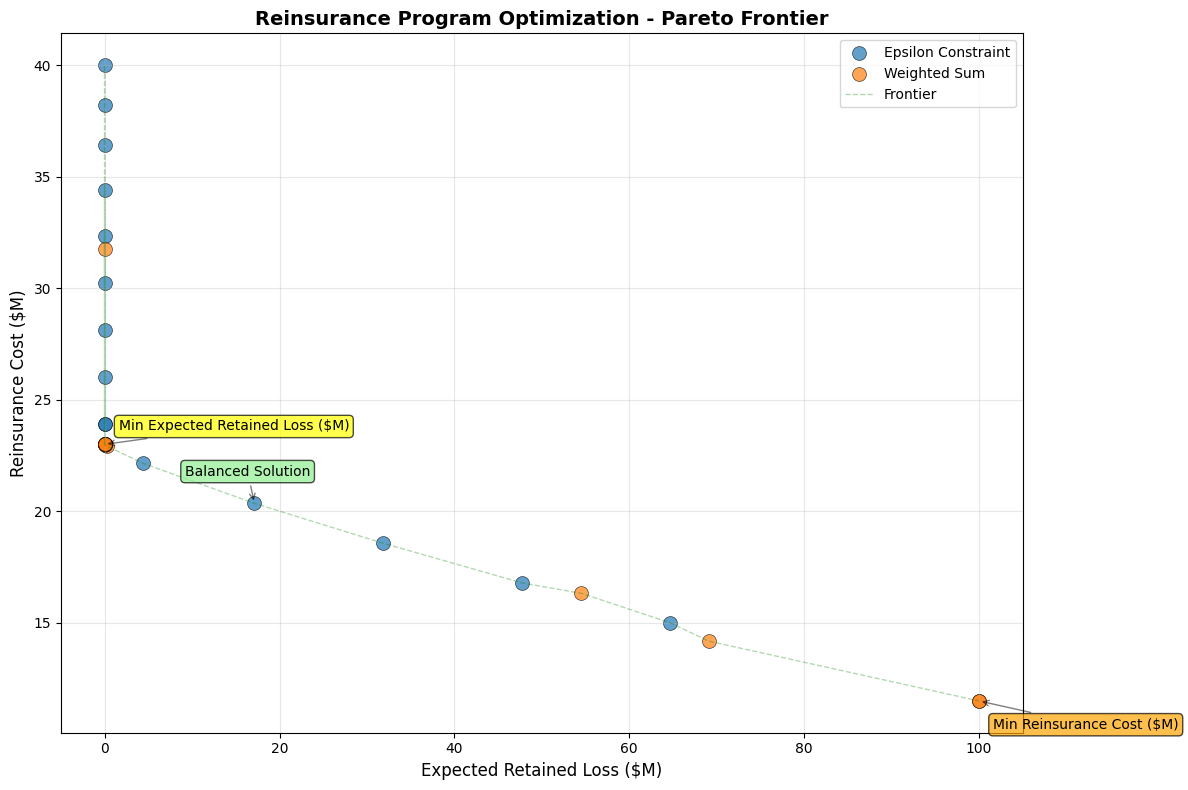


EXAMPLE 2: CAPITAL ALLOCATION ACROSS LINES

1. WEIGHTED SUM METHOD (Risk vs Return)
------------------------------
Found 15 Pareto-optimal allocations

Risk-Averse Allocation:
  Personal Lines: 95.0%
  Commercial Lines: 0.0%
  Portfolio VaR: $48.0M
  Expected ROE: 11.4%

Return-Seeking Allocation:
  Personal Lines: 0.0%
  Commercial Lines: 105.0%
  Portfolio VaR: $83.6M
  Expected ROE: 16.9%

2. EPSILON-CONSTRAINT METHOD (Constrain Risk)
------------------------------
Found 5 Pareto-optimal allocations

Moderate Risk Limit (VaR ≤ $61.1M):
  Personal Lines: 51.7%
  Commercial Lines: 53.3%
  Achieved ROE: 15.3%
  Actual VaR: $61.1M


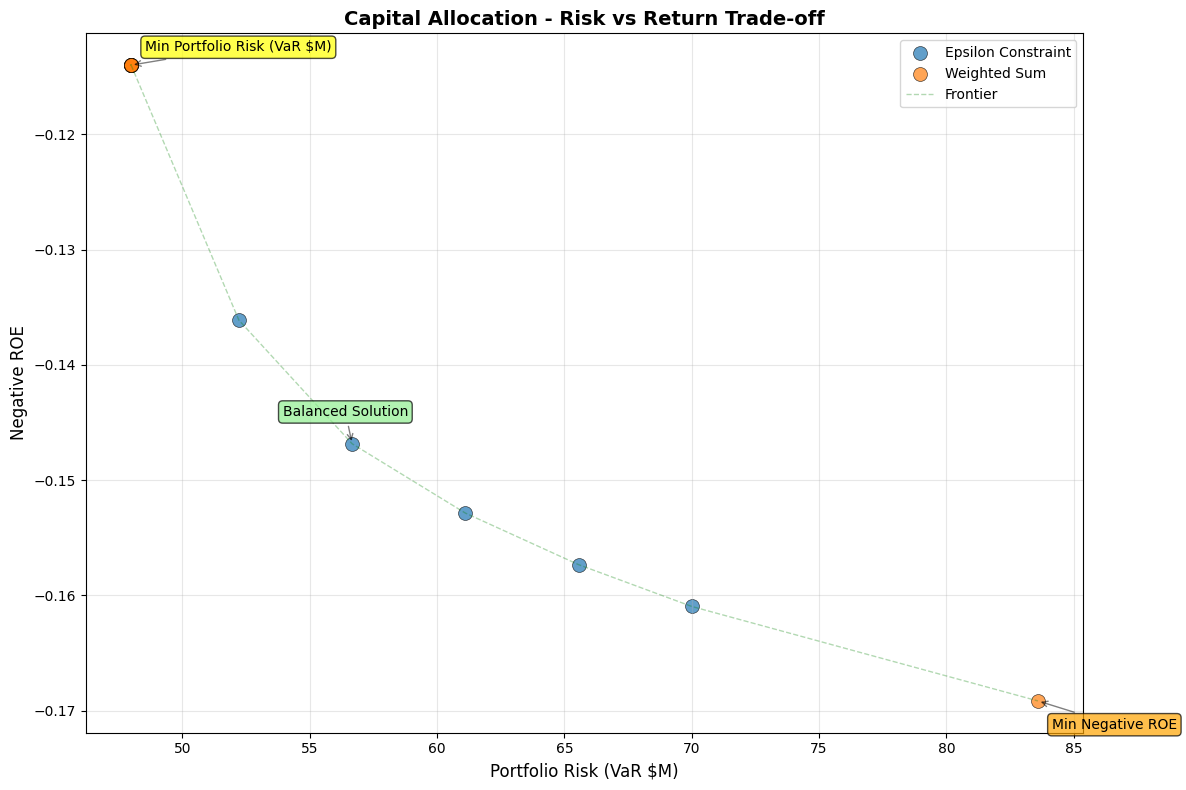


OPTIMIZATION SUMMARY

Reinsurance Optimization:
  Total solutions found: 35
  Loss range: $0.0M - $100.0M
  Cost range: $11.5M - $40.0M

Capital Allocation:
  Total solutions found: 20
  Risk range: $48.0M - $83.6M
  ROE range: 11.4% - 16.9%

Key Insights:
• Weighted Sum: Efficient for convex frontiers, intuitive weights
• Epsilon-Constraint: Handles non-convex regions, natural for risk limits
• Both methods provide complementary views of the trade-off space
• Actuarial judgment needed to select final solution from frontier


In [ ]:
"""
Pareto Frontier Optimization for P&C Insurance Decisions
=========================================================
Implementation of weighted sum and epsilon-constraint methods for 
multi-objective optimization in actuarial applications.
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, NonlinearConstraint
from typing import List, Dict, Callable, Tuple
import warnings
warnings.filterwarnings('ignore')


class ParetoFrontier:
    """
    Compute Pareto frontier for insurance portfolio optimization.
    
    Typical P&C applications include:
    - Reinsurance structure optimization (retention vs cost)
    - Capital allocation (risk vs return)
    - Reserve adequacy (surplus vs competitiveness)
    """
    
    def __init__(self, objectives: List[Callable], constraints: List = None):
        """
        Initialize Pareto frontier solver.
        
        Args:
            objectives: List of objective functions to minimize
            constraints: Optional list of optimization constraints
        """
        self.objectives = objectives
        self.constraints = constraints if constraints else []
        
    def weighted_sum_method(self, weights_grid: List[Tuple]) -> List[Dict]:
        """
        Generate Pareto frontier using weighted sum scalarization.
        
        This method is computationally efficient and intuitive for stakeholders
        who can express preferences as relative weights.
        
        Args:
            weights_grid: List of weight tuples, each summing to 1
            
        Returns:
            List of Pareto-optimal solutions with objectives and weights
        """
        frontier = []
        
        for i, weights in enumerate(weights_grid):
            # Verify weights sum to 1
            assert abs(sum(weights) - 1.0) < 1e-6, f"Weights must sum to 1, got {sum(weights)}"
            
            # Combined objective function
            def combined_objective(x):
                return sum(w * obj(x) for w, obj in zip(weights, self.objectives))
            
            # Use varied starting points for better exploration
            # This helps avoid local minima in non-convex problems
            x0_retention = 0.1 + 0.8 * (i / len(weights_grid))
            x0_coverage = 0.9 - 0.7 * (i / len(weights_grid))
            
            # Optimize using Sequential Least Squares Programming
            result = minimize(
                combined_objective,
                x0=[x0_retention, x0_coverage],
                bounds=[(0, 1), (0, 2)],  # Extended bounds for coverage flexibility
                constraints=self.constraints,
                method='SLSQP',
                options={'disp': False, 'maxiter': 200}
            )
            
            if result.success:
                # Evaluate all objectives at solution point
                obj_values = [obj(result.x) for obj in self.objectives]
                frontier.append({
                    'x': result.x,
                    'objectives': obj_values,
                    'weights': weights,
                    'method': 'weighted_sum'
                })
                
        return frontier
    
    def epsilon_constraint_method(self, epsilon_grid: List[List[float]]) -> List[Dict]:
        """
        Generate Pareto frontier using epsilon-constraint method.
        
        This method can find solutions in non-convex regions and is ideal
        when some objectives have natural constraint thresholds (e.g., 
        regulatory minimums, risk limits).
        
        Args:
            epsilon_grid: List of epsilon values for constraining secondary objectives
            
        Returns:
            List of Pareto-optimal solutions with objectives and epsilon values
        """
        frontier = []
        
        for eps_values in epsilon_grid:
            # Primary objective: minimize first objective
            def primary_objective(x):
                return self.objectives[0](x)
            
            # Create constraints for other objectives
            additional_constraints = []
            for i, obj in enumerate(self.objectives[1:], 1):
                # Each secondary objective must be <= its epsilon value
                additional_constraints.append(
                    NonlinearConstraint(
                        obj, 
                        lb=-np.inf, 
                        ub=eps_values[i-1],
                        keep_feasible=False
                    )
                )
            
            # Combine original and epsilon constraints
            all_constraints = self.constraints + additional_constraints
            
            # Optimize with multiple starting points for robustness
            for start_point in [[0.3, 0.7], [0.5, 0.5], [0.7, 0.3]]:
                result = minimize(
                    primary_objective,
                    x0=start_point,
                    bounds=[(0, 1), (0, 2)],
                    constraints=all_constraints,
                    method='SLSQP',
                    options={'disp': False, 'maxiter': 200}
                )
                
                if result.success:
                    obj_values = [obj(result.x) for obj in self.objectives]
                    frontier.append({
                        'x': result.x,
                        'objectives': obj_values,
                        'epsilon': eps_values,
                        'method': 'epsilon_constraint'
                    })
                    break  # Use first successful result
                    
        return frontier
    
    def plot_frontier(self, frontier: List[Dict], obj_names: List[str] = None,
                     title: str = 'Pareto Frontier - Insurance Optimization'):
        """
        Visualize Pareto frontier with actuarial annotations.
        
        Args:
            frontier: List of Pareto-optimal solutions
            obj_names: Names for objectives (default: ['Obj 1', 'Obj 2'])
            title: Plot title
        """
        if not frontier:
            print("No valid solutions found in frontier")
            return
            
        objectives = np.array([f['objectives'] for f in frontier])
        
        if obj_names is None:
            obj_names = [f'Objective {i+1}' for i in range(objectives.shape[1])]
        
        if objectives.shape[1] == 2:
            # 2D Pareto frontier plot
            plt.figure(figsize=(12, 8))
            
            # Color by method if available
            methods = [f.get('method', 'unknown') for f in frontier]
            method_colors = {'weighted_sum': 'blue', 'epsilon_constraint': 'red', 'unknown': 'gray'}
            colors = [method_colors.get(m, 'gray') for m in methods]
            
            # Main scatter plot
            for method in set(methods):
                mask = [m == method for m in methods]
                method_objectives = objectives[mask]
                if len(method_objectives) > 0:
                    plt.scatter(method_objectives[:, 0], method_objectives[:, 1],
                              s=100, alpha=0.7, edgecolors='black', linewidth=0.5,
                              label=method.replace('_', ' ').title())
            
            # Connect points to show frontier
            sorted_idx = np.argsort(objectives[:, 0])
            plt.plot(objectives[sorted_idx, 0], objectives[sorted_idx, 1],
                    'g--', alpha=0.3, linewidth=1, label='Frontier')
            
            # Labels and formatting
            plt.xlabel(obj_names[0], fontsize=12)
            plt.ylabel(obj_names[1], fontsize=12)
            plt.title(title, fontsize=14, fontweight='bold')
            plt.grid(True, alpha=0.3)
            plt.legend(loc='best')
            
            # Annotate key solutions
            self._annotate_key_points(objectives, obj_names)
            
            plt.tight_layout()
            plt.show()
            
        elif objectives.shape[1] == 3:
            # 3D Pareto frontier plot
            fig = plt.figure(figsize=(12, 9))
            ax = fig.add_subplot(111, projection='3d')
            
            scatter = ax.scatter(objectives[:, 0], objectives[:, 1], objectives[:, 2],
                               c=range(len(objectives)), cmap='viridis', s=50, alpha=0.7)
            
            ax.set_xlabel(obj_names[0], fontsize=10)
            ax.set_ylabel(obj_names[1], fontsize=10)
            ax.set_zlabel(obj_names[2], fontsize=10)
            ax.set_title(title, fontsize=12, fontweight='bold')
            
            plt.colorbar(scatter, label='Solution Index')
            plt.tight_layout()
            plt.show()
    
    def _annotate_key_points(self, objectives: np.ndarray, obj_names: List[str]):
        """Add annotations for key solutions on the Pareto frontier."""
        # Extreme points
        min_obj1_idx = np.argmin(objectives[:, 0])
        min_obj2_idx = np.argmin(objectives[:, 1])
        
        plt.annotate(f'Min {obj_names[0]}',
                    (objectives[min_obj1_idx, 0], objectives[min_obj1_idx, 1]),
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', color='black', alpha=0.5))
        
        plt.annotate(f'Min {obj_names[1]}',
                    (objectives[min_obj2_idx, 0], objectives[min_obj2_idx, 1]),
                    xytext=(10, -20), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='orange', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', color='black', alpha=0.5))
        
        # Balanced solution (closest to utopia point)
        obj_norm = (objectives - objectives.min(axis=0)) / (objectives.max(axis=0) - objectives.min(axis=0) + 1e-10)
        distances = np.sqrt(np.sum(obj_norm**2, axis=1))
        balanced_idx = np.argmin(distances)
        
        plt.annotate('Balanced Solution',
                    (objectives[balanced_idx, 0], objectives[balanced_idx, 1]),
                    xytext=(-50, 20), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', color='black', alpha=0.5))


# ==============================================================================
# P&C ACTUARIAL EXAMPLE 1: REINSURANCE OPTIMIZATION
# ==============================================================================

def reinsurance_example():
    """
    Example: Optimize reinsurance program balancing retention and cost.
    
    This is a common P&C actuarial problem where we need to find the optimal
    retention level and coverage limit that balances:
    1. Expected retained losses (minimize)
    2. Reinsurance premium costs (minimize)
    """
    print("=" * 70)
    print("EXAMPLE 1: REINSURANCE OPTIMIZATION")
    print("=" * 70)
    
    def expected_retained_loss(x):
        """
        Expected retained losses as function of retention and limit.
        
        Args:
            x: [retention_ratio, coverage_limit_ratio]
        """
        retention, coverage = x
        # Simplified loss model with severity and frequency components
        base_loss = 100  # Million USD
        retention_factor = retention**1.2  # Non-linear retention impact
        coverage_benefit = 1 - 0.7 * (1 - np.exp(-2 * coverage))
        return base_loss * retention_factor * coverage_benefit
    
    def reinsurance_cost(x):
        """
        Reinsurance premium based on retention and coverage.
        
        Higher coverage and lower retention = higher premium
        """
        retention, coverage = x
        base_premium = 20  # Million USD
        # Premium increases with coverage and decreases with retention
        premium_factor = (1 - retention * 0.5) * (1 + coverage * 0.8)
        loading_factor = 1.15  # Typical reinsurer loading
        return base_premium * premium_factor * loading_factor
    
    # Set up optimization
    objectives = [expected_retained_loss, reinsurance_cost]
    
    # Constraint: Total program cost must be reasonable
    constraints = [
        NonlinearConstraint(
            lambda x: expected_retained_loss(x) + reinsurance_cost(x),
            lb=0, ub=150  # Total cost cap at 150M
        )
    ]
    
    pareto = ParetoFrontier(objectives, constraints)
    
    # Method 1: Weighted Sum
    print("\n1. WEIGHTED SUM METHOD")
    print("-" * 30)
    
    # Generate weight combinations emphasizing different priorities
    weights_grid = []
    for i in range(20):
        w1 = i / 19  # From 0 to 1
        w2 = 1 - w1
        weights_grid.append((w1, w2))
    
    frontier_ws = pareto.weighted_sum_method(weights_grid)
    
    # Display sample solutions
    print(f"Found {len(frontier_ws)} Pareto-optimal solutions")
    print("\nSample solutions (different risk appetites):")
    
    # Conservative (minimize retained loss)
    conservative = min(frontier_ws, key=lambda x: x['objectives'][0])
    print(f"\nConservative (80% loss, 20% cost weight):")
    print(f"  Retention: {conservative['x'][0]:.2%}")
    print(f"  Coverage: {conservative['x'][1]:.2f}x")
    print(f"  Expected Loss: ${conservative['objectives'][0]:.1f}M")
    print(f"  Reinsurance Cost: ${conservative['objectives'][1]:.1f}M")
    
    # Aggressive (minimize cost)
    aggressive = min(frontier_ws, key=lambda x: x['objectives'][1])
    print(f"\nAggressive (20% loss, 80% cost weight):")
    print(f"  Retention: {aggressive['x'][0]:.2%}")
    print(f"  Coverage: {aggressive['x'][1]:.2f}x")
    print(f"  Expected Loss: ${aggressive['objectives'][0]:.1f}M")
    print(f"  Reinsurance Cost: ${aggressive['objectives'][1]:.1f}M")
    
    # Method 2: Epsilon-Constraint
    print("\n2. EPSILON-CONSTRAINT METHOD")
    print("-" * 30)
    
    # Set epsilon values for reinsurance cost constraint
    epsilon_grid = []
    for cost_limit in np.linspace(15, 40, 15):  # Cost limits from 15M to 40M
        epsilon_grid.append([cost_limit])
    
    frontier_ec = pareto.epsilon_constraint_method(epsilon_grid)
    
    print(f"Found {len(frontier_ec)} Pareto-optimal solutions")
    print("\nSolutions at different cost constraints:")
    
    for i in [0, len(frontier_ec)//2, -1]:
        if i < len(frontier_ec):
            sol = frontier_ec[i]
            print(f"\nCost limit: ${sol['epsilon'][0]:.1f}M")
            print(f"  Retention: {sol['x'][0]:.2%}")
            print(f"  Coverage: {sol['x'][1]:.2f}x")
            print(f"  Expected Loss: ${sol['objectives'][0]:.1f}M")
            print(f"  Actual Cost: ${sol['objectives'][1]:.1f}M")
    
    # Combine and plot
    all_solutions = frontier_ws + frontier_ec
    pareto.plot_frontier(
        all_solutions,
        obj_names=['Expected Retained Loss ($M)', 'Reinsurance Cost ($M)'],
        title='Reinsurance Program Optimization - Pareto Frontier'
    )
    
    return pareto, all_solutions


# ==============================================================================
# P&C ACTUARIAL EXAMPLE 2: CAPITAL ALLOCATION
# ==============================================================================

def capital_allocation_example():
    """
    Example: Optimize capital allocation across business lines.
    
    Balance between:
    1. Portfolio risk (VaR or TVaR)
    2. Expected return (ROE)
    3. Diversification benefit
    """
    print("\n" + "=" * 70)
    print("EXAMPLE 2: CAPITAL ALLOCATION ACROSS LINES")
    print("=" * 70)
    
    def portfolio_risk(x):
        """
        Portfolio Value-at-Risk (simplified model).
        
        Args:
            x: [allocation_personal_lines, allocation_commercial]
        """
        personal, commercial = x
        # Standalone risks
        risk_personal = 50 * personal**0.8
        risk_commercial = 80 * commercial**0.9
        # Correlation benefit
        correlation = 0.3
        diversified_risk = np.sqrt(
            risk_personal**2 + risk_commercial**2 + 
            2 * correlation * risk_personal * risk_commercial
        )
        return diversified_risk
    
    def negative_roe(x):
        """
        Negative expected ROE (for minimization).
        """
        personal, commercial = x
        # Expected returns differ by line
        roe_personal = 0.12 * personal
        roe_commercial = 0.18 * commercial * (1 - 0.1 * commercial)  # Diminishing returns
        combined_roe = roe_personal + roe_commercial
        return -combined_roe  # Negative for minimization
    
    def concentration_penalty(x):
        """
        Penalty for concentration risk (regulatory concern).
        """
        personal, commercial = x
        # Herfindahl index for concentration
        total = personal + commercial
        if total == 0:
            return 0
        hhi = (personal/total)**2 + (commercial/total)**2
        return hhi * 100  # Scale for visibility
    
    # Three-objective optimization
    objectives = [portfolio_risk, negative_roe, concentration_penalty]
    
    # Constraints: allocations must sum to 1
    constraints = [
        NonlinearConstraint(
            lambda x: x[0] + x[1],
            lb=0.95, ub=1.05  # Allow small deviation for numerical stability
        )
    ]
    
    pareto = ParetoFrontier(objectives[:2], constraints)  # Use first 2 objectives for 2D viz
    
    print("\n1. WEIGHTED SUM METHOD (Risk vs Return)")
    print("-" * 30)
    
    # Generate weights for different risk preferences
    weights_grid = []
    for risk_aversion in np.linspace(0, 1, 15):
        w_risk = risk_aversion
        w_return = 1 - risk_aversion
        weights_grid.append((w_risk, w_return))
    
    frontier_ws = pareto.weighted_sum_method(weights_grid)
    
    print(f"Found {len(frontier_ws)} Pareto-optimal allocations")
    
    # Analyze key allocations
    if frontier_ws:
        # Risk-averse allocation
        risk_averse = min(frontier_ws, key=lambda x: x['objectives'][0])
        print(f"\nRisk-Averse Allocation:")
        print(f"  Personal Lines: {risk_averse['x'][0]:.1%}")
        print(f"  Commercial Lines: {risk_averse['x'][1]:.1%}")
        print(f"  Portfolio VaR: ${risk_averse['objectives'][0]:.1f}M")
        print(f"  Expected ROE: {-risk_averse['objectives'][1]:.1%}")
        
        # Return-seeking allocation
        return_seeking = min(frontier_ws, key=lambda x: x['objectives'][1])
        print(f"\nReturn-Seeking Allocation:")
        print(f"  Personal Lines: {return_seeking['x'][0]:.1%}")
        print(f"  Commercial Lines: {return_seeking['x'][1]:.1%}")
        print(f"  Portfolio VaR: ${return_seeking['objectives'][0]:.1f}M")
        print(f"  Expected ROE: {-return_seeking['objectives'][1]:.1%}")
    
    print("\n2. EPSILON-CONSTRAINT METHOD (Constrain Risk)")
    print("-" * 30)
    
    # Set risk limits
    epsilon_grid = []
    for risk_limit in np.linspace(30, 70, 10):
        epsilon_grid.append([risk_limit])  # Constraint on negative ROE not needed here
    
    # For epsilon-constraint, we minimize return subject to risk constraint
    # So swap objectives
    pareto_ec = ParetoFrontier([negative_roe, portfolio_risk], constraints)
    frontier_ec = pareto_ec.epsilon_constraint_method(epsilon_grid)
    
    print(f"Found {len(frontier_ec)} Pareto-optimal allocations")
    
    if frontier_ec:
        # Sample allocation at moderate risk limit
        mid_solution = frontier_ec[len(frontier_ec)//2] if frontier_ec else None
        if mid_solution:
            print(f"\nModerate Risk Limit (VaR ≤ ${mid_solution['epsilon'][0]:.1f}M):")
            print(f"  Personal Lines: {mid_solution['x'][0]:.1%}")
            print(f"  Commercial Lines: {mid_solution['x'][1]:.1%}")
            print(f"  Achieved ROE: {-mid_solution['objectives'][0]:.1%}")
            print(f"  Actual VaR: ${mid_solution['objectives'][1]:.1f}M")
    
    # Plot frontier (swap objectives back for consistent view)
    if frontier_ec:
        for sol in frontier_ec:
            sol['objectives'] = [sol['objectives'][1], sol['objectives'][0]]
    
    all_solutions = frontier_ws + frontier_ec
    if all_solutions:
        pareto.plot_frontier(
            all_solutions,
            obj_names=['Portfolio Risk (VaR $M)', 'Negative ROE'],
            title='Capital Allocation - Risk vs Return Trade-off'
        )
    
    return pareto, all_solutions


# ==============================================================================
# MAIN EXECUTION
# ==============================================================================

if __name__ == "__main__":
    # Run reinsurance optimization example
    pareto_reins, solutions_reins = reinsurance_example()
    
    # Run capital allocation example
    pareto_capital, solutions_capital = capital_allocation_example()
    
    # Summary statistics
    print("\n" + "=" * 70)
    print("OPTIMIZATION SUMMARY")
    print("=" * 70)
    
    print(f"\nReinsurance Optimization:")
    print(f"  Total solutions found: {len(solutions_reins)}")
    if solutions_reins:
        obj_values = np.array([s['objectives'] for s in solutions_reins])
        print(f"  Loss range: ${obj_values[:, 0].min():.1f}M - ${obj_values[:, 0].max():.1f}M")
        print(f"  Cost range: ${obj_values[:, 1].min():.1f}M - ${obj_values[:, 1].max():.1f}M")
    
    print(f"\nCapital Allocation:")
    print(f"  Total solutions found: {len(solutions_capital)}")
    if solutions_capital:
        obj_values = np.array([s['objectives'] for s in solutions_capital])
        print(f"  Risk range: ${obj_values[:, 0].min():.1f}M - ${obj_values[:, 0].max():.1f}M")
        print(f"  ROE range: {-obj_values[:, 1].max():.1%} - {-obj_values[:, 1].min():.1%}")
    
    print("\nKey Insights:")
    print("• Weighted Sum: Efficient for convex frontiers, intuitive weights")
    print("• Epsilon-Constraint: Handles non-convex regions, natural for risk limits")
    print("• Both methods provide complementary views of the trade-off space")
    print("• Actuarial judgment needed to select final solution from frontier")

In [ ]:
class NSGA2:
    """Non-dominated Sorting Genetic Algorithm II for multi-objective optimization."""

    def __init__(self, objectives, bounds, pop_size=50):
        self.objectives = objectives
        self.bounds = bounds
        self.pop_size = pop_size

    def non_dominated_sort(self, population, fitnesses):
        """Sort population into non-dominated fronts."""

        n = len(population)
        domination_count = np.zeros(n)
        dominated_by = [[] for _ in range(n)]
        fronts = [[]]

            # Calculate domination relationships
        for i in range(n):
            for j in range(i + 1, n):
                if self.dominates(fitnesses[i], fitnesses[j]):
                    dominated_by[i].append(j)
                    domination_count[j] += 1
                elif self.dominates(fitnesses[j], fitnesses[i]):
                    dominated_by[j].append(i)
                    domination_count[i] += 1

        # Find first front
        for i in range(n):
            if domination_count[i] == 0:
                fronts[0].append(i)

        # Find remaining fronts
        current_front = 0

        while fronts[current_front]:
            next_front = []

        for i in fronts[current_front]:
            for j in dominated_by[i]:
                domination_count[j] -= 1
                if domination_count[j] == 0:
                    next_front.append(j)
                    current_front += 1
                    fronts.append(next_front)

        return fronts[:-1]
    # Remove empty last front

    def dominates(self, f1, f2):
        """Check if f1 dominates f2."""
        return all(f1 <= f2) and any(f1 < f2)

    def crowding_distance(self, fitnesses):
        """Calculate crowding distance for diversity."""

        n, m = fitnesses.shape
        distances = np.zeros(n)

        for obj in range(m):
            # Sort by objective
            sorted_idx = np.argsort(fitnesses[:, obj])

            # Boundary points get infinite distance
            distances[sorted_idx[0]] = np.inf
            distances[sorted_idx[-1]] = np.inf

            # Calculate distances for interior points
            obj_range = fitnesses[sorted_idx[-1], obj] - fitnesses[sorted_idx[0], obj]

            if obj_range > 0:
                for i in range(1, n - 1):
                    distances[sorted_idx[i]] += (fitnesses[sorted_idx[i + 1], obj] - fitnesses[sorted_idx[i - 1], obj]) / obj_range

        return distances

    def optimize(self, n_generations=100):
        """Run NSGA-II optimization."""

        # Initialize population
        population = np.random.uniform(
            self.bounds[:, 0],
            self.bounds[:, 1],
            (self.pop_size, len(self.bounds))
        )

        for generation in range(n_generations):
            # Evaluate objectives
            fitnesses = np.array([
                [obj(ind) for obj in self.objectives]
                for ind in population
            ])

            # Non-dominated sorting
            fronts = self.non_dominated_sort(population, fitnesses)

            # Create offspring
            offspring = self.create_offspring(population)

            # Combine parent and offspring
            combined_pop = np.vstack([population, offspring])
            combined_fit = np.vstack([
                fitnesses,
                np.array([[obj(ind) for obj in self.objectives]
                for ind in offspring])
            ])

            # Select next generation
            new_population = []
            new_fitnesses = []

            for front in fronts:
                if len(new_population) + len(front) <= self.pop_size:
                    new_population.extend(combined_pop[front])
                    new_fitnesses.extend(combined_fit[front])
                else:
                    # Use crowding distance for selection
                    remaining = self.pop_size - len(new_population)
                    front_fit = combined_fit[front]
                    distances = self.crowding_distance(front_fit)
                    selected_idx = np.argsort(distances)[-remaining:]

                    for idx in selected_idx:
                        new_population.append(combined_pop[front[idx]])
                        new_fitnesses.append(combined_fit[front[idx]])
                        break

            population = np.array(new_population)
            fitnesses = np.array(new_fitnesses)

        # Return Pareto frontier
        final_fronts = self.non_dominated_sort(population, fitnesses)
        pareto_set = population[final_fronts[0]]
        pareto_front = fitnesses[final_fronts[0]]

        return pareto_set, pareto_front

    def create_offspring(self, population):
        """Generate offspring through crossover and mutation."""
        offspring = []

        for _ in range(self.pop_size):
            # Select parents (tournament selection)
            parents_idx = np.random.choice(len(population), 2, replace=False)
            parent1, parent2 = population[parents_idx]

            # Crossover (SBX)
            child = self.sbx_crossover(parent1, parent2)

            # Mutation (polynomial)
            child = self.polynomial_mutation(child)

            # Ensure bounds
            child = np.clip(child, self.bounds[:, 0], self.bounds[:, 1])

            offspring.append(child)

        return np.array(offspring)

    def sbx_crossover(self, parent1, parent2, eta=20):
        """Simulated binary crossover."""
        child = np.empty_like(parent1)

        for i in range(len(parent1)):
            if np.random.rand() < 0.5:
                # Perform crossover
                if abs(parent1[i] - parent2[i]) > 1e-10:
                    if parent1[i] < parent2[i]:
                        y1, y2 = parent1[i], parent2[i]
                    else:
                        y1, y2 = parent2[i], parent1[i]

                    beta = 1 + (2 * y1 / (y2 - y1))
                    alpha = 2 - beta ** (-(eta + 1))

                    u = np.random.rand()
                    if u <= 1 / alpha:
                        beta_q = (u * alpha) ** (1 / (eta + 1))
                    else:
                        beta_q = (1 / (2 - u * alpha)) ** (1 / (eta + 1))

                    child[i] = 0.5 * ((y1 + y2) - beta_q * (y2 - y1))
                else:
                    child[i] = parent1[i]
            else:
                child[i] = parent1[i]

        return child

    def polynomial_mutation(self, individual, eta=20, mutation_prob=0.1):
        """Polynomial mutation."""

        mutated = individual.copy()

        for i in range(len(individual)):
            if np.random.rand() < mutation_prob:
                y = individual[i]
                yl, yu = self.bounds[i]

                delta1 = (y - yl) / (yu - yl)
                delta2 = (yu - y) / (yu - yl)

                u = np.random.rand()

                if u <= 0.5:
                    delta_q = (2 * u + (1 - 2 * u) * (1 - delta1) ** (eta + 1)) ** (1 / (eta + 1)) - 1
                else:
                    delta_q = 1 - (2 * (1 - u) + 2 * (u - 0.5) * (1 - delta2) ** (eta + 1)) ** (1 / (eta + 1))

                mutated[i] = y + delta_q * (yu - yl)
                mutated[i] = np.clip(mutated[i], yl, yu)

        return mutated

# Example: Three-objective insurance optimization
def premium_objective(x):
    """Minimize premium cost."""
    retention, primary_limit, excess_limit = x
    return 0.02 * primary_limit + 0.01 * excess_limit + 0.005 / (1 + retention)

def risk_objective(x):
    """Minimize retained risk."""
    retention, primary_limit, excess_limit = x
    return retention + max(0, 1 - primary_limit - excess_limit)

def volatility_objective(x):
    """Minimize earnings volatility."""
    retention, primary_limit, excess_limit = x
    return 0.5 * retention - 0.3 * primary_limit - 0.2 * excess_limit + 0.8

# Optimize
objectives = [premium_objective, risk_objective, volatility_objective]
bounds = np.array([
    [0, 1],  # retention
    [0, 2],  # primary_limit
    [0, 3]   # excess_limit
])

nsga2 = NSGA2(objectives, bounds, pop_size=100)
pareto_set, pareto_front = nsga2.optimize(n_generations=50)

# Visualize 3D Pareto frontier
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pareto_front[:, 0], pareto_front[:, 1], pareto_front[:, 2])
ax.set_xlabel('Premium Cost')
ax.set_ylabel('Retained Risk')
ax.set_zlabel('Volatility')
ax.set_title('3D Pareto Frontier - Insurance Optimization')
plt.show()

In [ ]:
"""
NSGA-II (Non-dominated Sorting Genetic Algorithm II) Implementation
for Multi-Objective Optimization in P&C Insurance Applications
==================================================================
"""

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import List, Callable, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')


class NSGA2:
    """
    Non-dominated Sorting Genetic Algorithm II for multi-objective optimization.
    
    Particularly suited for P&C actuarial problems with competing objectives like:
    - Risk vs Return trade-offs
    - Premium adequacy vs Market competitiveness
    - Retention vs Reinsurance cost optimization
    """
    
    def __init__(self, 
                objectives: List[Callable],
                bounds: np.ndarray,
                pop_size: int = 50,
                crossover_prob: float = 0.9,
                mutation_prob: float = None,
                eta_crossover: float = 20,
                eta_mutation: float = 20):
        """
        Initialize NSGA-II optimizer.
        
        Args:
            objectives: List of objective functions to minimize
            bounds: Array of shape (n_vars, 2) with [min, max] for each variable
            pop_size: Population size (should be even)
            crossover_prob: Probability of crossover
            mutation_prob: Probability of mutation (default: 1/n_vars)
            eta_crossover: Distribution index for SBX crossover
            eta_mutation: Distribution index for polynomial mutation
        """
        self.objectives = objectives
        self.n_objectives = len(objectives)
        self.bounds = bounds
        self.n_vars = len(bounds)
        self.pop_size = pop_size if pop_size % 2 == 0 else pop_size + 1
        self.crossover_prob = crossover_prob
        self.mutation_prob = mutation_prob if mutation_prob else 1.0 / self.n_vars
        self.eta_crossover = eta_crossover
        self.eta_mutation = eta_mutation
        
    def dominates(self, f1: np.ndarray, f2: np.ndarray) -> bool:
        """
        Check if solution f1 dominates solution f2.
        
        f1 dominates f2 if:
        - f1 is no worse than f2 in all objectives
        - f1 is strictly better than f2 in at least one objective
        """
        return np.all(f1 <= f2) and np.any(f1 < f2)
    
    def non_dominated_sort(self, population: np.ndarray, fitnesses: np.ndarray) -> List[List[int]]:
        """
        Sort population into non-dominated fronts using fast non-dominated sorting.
        
        Returns:
            List of fronts, where each front is a list of population indices
        """
        n = len(population)
        
        # Initialize domination data structures
        domination_count = np.zeros(n, dtype=int)  # Number of solutions dominating i
        dominated_by = [[] for _ in range(n)]       # Solutions dominated by i
        
        # Calculate domination relationships
        for i in range(n):
            for j in range(i + 1, n):
                if self.dominates(fitnesses[i], fitnesses[j]):
                    dominated_by[i].append(j)
                    domination_count[j] += 1
                elif self.dominates(fitnesses[j], fitnesses[i]):
                    dominated_by[j].append(i)
                    domination_count[i] += 1
        
        # Find first front (non-dominated solutions)
        fronts = [[]]
        for i in range(n):
            if domination_count[i] == 0:
                fronts[0].append(i)
        
        # Find remaining fronts iteratively
        current_front = 0
        # Guard the loop with a length check to avoid index errors when no further fronts are appended
        while current_front < len(fronts) and fronts[current_front]:
            next_front = []
            
            # For each solution in current front
            for i in fronts[current_front]:
                # Reduce domination count for dominated solutions
                for j in dominated_by[i]:
                    domination_count[j] -= 1
                    # If domination count becomes 0, add to next front
                    if domination_count[j] == 0:
                        next_front.append(j)
            
            if next_front:  # Only add non-empty fronts
                fronts.append(next_front)
            current_front += 1
        
        # If the last front is empty, remove it
        return fronts[:-1] if (fronts and not fronts[-1]) else fronts
    
    def crowding_distance(self, fitnesses: np.ndarray) -> np.ndarray:
        """
        Calculate crowding distance for diversity preservation.
        
        Crowding distance estimates the density of solutions surrounding a particular
        solution in the objective space.
        """
        n = len(fitnesses)
        if n <= 2:
            return np.full(n, np.inf)
        
        m = fitnesses.shape[1]
        distances = np.zeros(n)
        
        for obj_idx in range(m):
            # Sort by current objective
            sorted_indices = np.argsort(fitnesses[:, obj_idx])
            sorted_fitnesses = fitnesses[sorted_indices, obj_idx]
            
            # Boundary points get infinite distance
            distances[sorted_indices[0]] = np.inf
            distances[sorted_indices[-1]] = np.inf
            
            # Calculate distance contribution from this objective
            obj_range = sorted_fitnesses[-1] - sorted_fitnesses[0]
            
            if obj_range > 0:
                for i in range(1, n - 1):
                    distance_contribution = (sorted_fitnesses[i + 1] - sorted_fitnesses[i - 1]) / obj_range
                    distances[sorted_indices[i]] += distance_contribution
        
        return distances
    
    def tournament_selection(self, population: np.ndarray, fitnesses: np.ndarray,
                            fronts: List[List[int]], tournament_size: int = 2) -> int:
        """
        Binary tournament selection based on dominance rank and crowding distance.
        """
        # Create rank array
        ranks = np.zeros(len(population), dtype=int)
        for rank, front in enumerate(fronts):
            for idx in front:
                ranks[idx] = rank
        
        # Calculate crowding distances for entire population
        all_distances = np.zeros(len(population))
        for front in fronts:
            if front:
                front_fitnesses = fitnesses[front]
                front_distances = self.crowding_distance(front_fitnesses)
                for i, idx in enumerate(front):
                    all_distances[idx] = front_distances[i]
        
        # Tournament
        candidates = np.random.choice(len(population), tournament_size, replace=False)
        
        # Select based on rank (lower is better)
        best_rank = np.min(ranks[candidates])
        best_candidates = candidates[ranks[candidates] == best_rank]
        
        if len(best_candidates) == 1:
            return best_candidates[0]
        
        # If tied on rank, select based on crowding distance (higher is better)
        return best_candidates[np.argmax(all_distances[best_candidates])]
    
    def sbx_crossover(self, parent1: np.ndarray, parent2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Simulated Binary Crossover (SBX).
        
        Creates two offspring that maintain the spread of parent solutions.
        """
        child1 = parent1.copy()
        child2 = parent2.copy()
        
        if np.random.rand() > self.crossover_prob:
            return child1, child2
        
        for i in range(self.n_vars):
            if np.random.rand() < 0.5:
                if abs(parent1[i] - parent2[i]) > 1e-10:
                    # Order parents
                    if parent1[i] < parent2[i]:
                        y1, y2 = parent1[i], parent2[i]
                    else:
                        y1, y2 = parent2[i], parent1[i]
                    
                    # Calculate beta
                    yl, yu = self.bounds[i]
                    beta = 1.0 + (2.0 * (y1 - yl) / (y2 - y1 + 1e-10))
                    alpha = 2.0 - beta ** (-(self.eta_crossover + 1))
                    
                    u = np.random.rand()
                    if u <= 1.0 / alpha:
                        beta_q = (u * alpha) ** (1.0 / (self.eta_crossover + 1))
                    else:
                        beta_q = (1.0 / (2.0 - u * alpha)) ** (1.0 / (self.eta_crossover + 1))
                    
                    # Create offspring
                    c1 = 0.5 * ((y1 + y2) - beta_q * (y2 - y1))
                    c2 = 0.5 * ((y1 + y2) + beta_q * (y2 - y1))
                    
                    # Ensure bounds
                    c1 = np.clip(c1, yl, yu)
                    c2 = np.clip(c2, yl, yu)
                    
                    # Assign to children randomly
                    if np.random.rand() < 0.5:
                        child1[i], child2[i] = c1, c2
                    else:
                        child1[i], child2[i] = c2, c1
        
        return child1, child2
    
    def polynomial_mutation(self, individual: np.ndarray) -> np.ndarray:
        """
        Polynomial mutation operator.
        """
        mutated = individual.copy()
        
        for i in range(self.n_vars):
            if np.random.rand() < self.mutation_prob:
                y = individual[i]
                yl, yu = self.bounds[i]
                
                if yu - yl > 0:
                    delta1 = (y - yl) / (yu - yl)
                    delta2 = (yu - y) / (yu - yl)
                    
                    u = np.random.rand()
                    
                    if u <= 0.5:
                        delta_q = (2.0 * u + (1.0 - 2.0 * u) * 
                                  (1.0 - delta1) ** (self.eta_mutation + 1)) ** (1.0 / (self.eta_mutation + 1)) - 1.0
                    else:
                        delta_q = 1.0 - (2.0 * (1.0 - u) + 2.0 * (u - 0.5) * 
                                       (1.0 - delta2) ** (self.eta_mutation + 1)) ** (1.0 / (self.eta_mutation + 1))
                    
                    mutated[i] = y + delta_q * (yu - yl)
                    mutated[i] = np.clip(mutated[i], yl, yu)
        
        return mutated
    
    def create_offspring(self, population: np.ndarray, fitnesses: np.ndarray, 
                        fronts: List[List[int]]) -> np.ndarray:
        """
        Generate offspring population through selection, crossover, and mutation.
        """
        offspring = []
        
        for _ in range(self.pop_size // 2):
            # Select parents using tournament selection
            parent1_idx = self.tournament_selection(population, fitnesses, fronts)
            parent2_idx = self.tournament_selection(population, fitnesses, fronts)
            
            parent1 = population[parent1_idx]
            parent2 = population[parent2_idx]
            
            # Crossover
            child1, child2 = self.sbx_crossover(parent1, parent2)
            
            # Mutation
            child1 = self.polynomial_mutation(child1)
            child2 = self.polynomial_mutation(child2)
            
            offspring.extend([child1, child2])
        
        return np.array(offspring[:self.pop_size])  # Ensure correct size
    
    def optimize(self, n_generations: int = 100, verbose: bool = True) -> Tuple[np.ndarray, np.ndarray]:
        """
        Run NSGA-II optimization.
        
        Returns:
            pareto_set: Decision variables of Pareto optimal solutions
            pareto_front: Objective values of Pareto optimal solutions
        """
        # Initialize population randomly
        population = np.random.uniform(
            self.bounds[:, 0],
            self.bounds[:, 1],
            (self.pop_size, self.n_vars)
        )
        
        # Evolution loop
        for generation in range(n_generations):
            # Evaluate objectives for current population
            fitnesses = np.array([
                [obj(ind) for obj in self.objectives]
                for ind in population
            ])
            
            # Non-dominated sorting
            fronts = self.non_dominated_sort(population, fitnesses)
            
            # Create offspring
            offspring = self.create_offspring(population, fitnesses, fronts)
            
            # Evaluate offspring
            offspring_fitnesses = np.array([
                [obj(ind) for obj in self.objectives]
                for ind in offspring
            ])
            
            # Combine parent and offspring populations
            combined_pop = np.vstack([population, offspring])
            combined_fit = np.vstack([fitnesses, offspring_fitnesses])
            
            # Non-dominated sorting of combined population
            combined_fronts = self.non_dominated_sort(combined_pop, combined_fit)
            
            # Select next generation using elitism
            new_population = []
            new_population_indices = []
            
            for front in combined_fronts:
                if len(new_population) + len(front) <= self.pop_size:
                    # Add entire front
                    new_population_indices.extend(front)
                else:
                    # Use crowding distance to select from last front
                    remaining = self.pop_size - len(new_population_indices)
                    
                    # Calculate crowding distance for current front
                    front_fitnesses = combined_fit[front]
                    distances = self.crowding_distance(front_fitnesses)
                    
                    # Select individuals with highest crowding distance
                    sorted_indices = np.argsort(distances)[::-1]  # Sort descending
                    selected = [front[idx] for idx in sorted_indices[:remaining]]
                    new_population_indices.extend(selected)
                    break
            
            # Update population
            population = combined_pop[new_population_indices]
            fitnesses = combined_fit[new_population_indices]
            
            # Progress report
            if verbose and (generation + 1) % 10 == 0:
                n_pareto = len(self.non_dominated_sort(population, fitnesses)[0])
                print(f"Generation {generation + 1}/{n_generations}: "
                        f"{n_pareto} solutions in Pareto front")
        
        # Extract final Pareto front
        final_fronts = self.non_dominated_sort(population, fitnesses)
        pareto_indices = final_fronts[0]
        pareto_set = population[pareto_indices]
        pareto_front = fitnesses[pareto_indices]
        
        return pareto_set, pareto_front
    
    def plot_pareto_front(self, pareto_front: np.ndarray, 
                        obj_names: Optional[List[str]] = None,
                        title: str = "Pareto Front") -> None:
        """
        Visualize the Pareto front for 2D or 3D problems.
        """
        n_obj = pareto_front.shape[1]
        
        if obj_names is None:
            obj_names = [f"Objective {i+1}" for i in range(n_obj)]
        
        if n_obj == 2:
            # 2D plot
            plt.figure(figsize=(10, 8))
            plt.scatter(pareto_front[:, 0], pareto_front[:, 1], 
                        s=100, c='blue', alpha=0.7, edgecolors='black')
            
            # Sort and connect points
            sorted_indices = np.argsort(pareto_front[:, 0])
            plt.plot(pareto_front[sorted_indices, 0], 
                    pareto_front[sorted_indices, 1], 
                    'b--', alpha=0.3)
            
            plt.xlabel(obj_names[0], fontsize=12)
            plt.ylabel(obj_names[1], fontsize=12)
            plt.title(title, fontsize=14, fontweight='bold')
            plt.grid(True, alpha=0.3)
            
            # Annotate extremes
            min_obj1_idx = np.argmin(pareto_front[:, 0])
            min_obj2_idx = np.argmin(pareto_front[:, 1])
            
            plt.annotate(f'Min {obj_names[0]}',
                        xy=(pareto_front[min_obj1_idx, 0], pareto_front[min_obj1_idx, 1]),
                        xytext=(10, 10), textcoords='offset points',
                        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5),
                        arrowprops=dict(arrowstyle='->', color='black'))
            
            plt.annotate(f'Min {obj_names[1]}',
                        xy=(pareto_front[min_obj2_idx, 0], pareto_front[min_obj2_idx, 1]),
                        xytext=(10, -20), textcoords='offset points',
                        bbox=dict(boxstyle='round', facecolor='orange', alpha=0.5),
                        arrowprops=dict(arrowstyle='->', color='black'))
            
        elif n_obj == 3:
            # 3D plot
            fig = plt.figure(figsize=(12, 9))
            ax = fig.add_subplot(111, projection='3d')
            
            scatter = ax.scatter(pareto_front[:, 0], 
                                pareto_front[:, 1], 
                                pareto_front[:, 2],
                                s=50, c='blue', alpha=0.7, edgecolors='black')
            
            ax.set_xlabel(obj_names[0], fontsize=10)
            ax.set_ylabel(obj_names[1], fontsize=10)
            ax.set_zlabel(obj_names[2], fontsize=10)
            ax.set_title(title, fontsize=12, fontweight='bold')
            
            # Add grid
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


# ==============================================================================
# P&C ACTUARIAL EXAMPLE: THREE-OBJECTIVE REINSURANCE OPTIMIZATION
# ==============================================================================

def reinsurance_optimization_example():
    """
    Example: Optimize reinsurance structure with three competing objectives.
    
    Decision Variables:
    - x[0]: Retention level (as fraction of exposure)
    - x[1]: Primary layer limit (in millions)
    - x[2]: Excess layer limit (in millions)
    
    Objectives:
    1. Minimize total reinsurance premium
    2. Minimize retained risk (VaR)
    3. Minimize earnings volatility
    """
    print("=" * 70)
    print("THREE-OBJECTIVE REINSURANCE STRUCTURE OPTIMIZATION")
    print("=" * 70)
    
    def premium_objective(x):
        """
        Total reinsurance premium cost.
        
        Premium increases with coverage and decreases with retention.
        """
        retention, primary_limit, excess_limit = x
        
        # Base premiums for each layer
        primary_rate = 0.025  # 2.5% rate on line for primary
        excess_rate = 0.015   # 1.5% rate on line for excess
        
        # Retention discount (higher retention = lower premium)
        retention_factor = np.exp(-2 * retention)
        
        # Calculate premiums
        primary_premium = primary_rate * primary_limit * (1 + retention_factor)
        excess_premium = excess_rate * excess_limit * (1 + 0.5 * retention_factor)
        
        # Loading for small retentions (moral hazard adjustment)
        small_retention_loading = 0.1 * np.exp(-5 * retention)
        
        total_premium = primary_premium + excess_premium + small_retention_loading
        return total_premium
    
    def risk_objective(x):
        """
        Retained risk measured as 99.5% VaR.
        
        Risk increases with retention and decreases with coverage.
        """
        retention, primary_limit, excess_limit = x
        
        # Base risk components
        frequency_risk = 2.0 * retention ** 0.8
        severity_risk = 3.0 * np.exp(-0.5 * (primary_limit + excess_limit))
        
        # Tail risk for uncovered losses
        total_coverage = primary_limit + excess_limit
        tail_risk = 1.5 * max(0, 1 - total_coverage / 5) ** 2
        
        # Aggregate risk measure
        var_995 = frequency_risk + severity_risk + tail_risk
        return var_995
    
    def volatility_objective(x):
        """
        Earnings volatility (coefficient of variation).
        
        Balance between retention volatility and premium stability.
        """
        retention, primary_limit, excess_limit = x
        
        # Retained loss volatility
        retained_volatility = 0.4 * retention ** 0.5
        
        # Coverage reduces volatility but with diminishing returns
        coverage_benefit = 0.3 * (1 - np.exp(-0.5 * primary_limit))
        coverage_benefit += 0.2 * (1 - np.exp(-0.3 * excess_limit))
        
        # Net volatility
        net_volatility = retained_volatility * (1 - coverage_benefit) + 0.1
        return net_volatility
    
    # Set up optimization problem
    objectives = [premium_objective, risk_objective, volatility_objective]
    
    # Variable bounds
    bounds = np.array([
        [0.1, 0.9],   # Retention: 10% to 90%
        [0.5, 5.0],   # Primary limit: $0.5M to $5M
        [0.0, 10.0]   # Excess limit: $0M to $10M
    ])
    
    # Initialize and run NSGA-II
    print("\nRunning NSGA-II optimization...")
    print("-" * 30)
    
    nsga2 = NSGA2(
        objectives=objectives,
        bounds=bounds,
        pop_size=100,
        crossover_prob=0.9,
        mutation_prob=None,  # Will use 1/n_vars
        eta_crossover=20,
        eta_mutation=20
    )
    
    # Optimize
    pareto_set, pareto_front = nsga2.optimize(n_generations=100, verbose=True)
    
    # Analysis of results
    print("\n" + "=" * 70)
    print("OPTIMIZATION RESULTS")
    print("=" * 70)
    
    print(f"\nFound {len(pareto_set)} Pareto-optimal solutions")
    
    # Find extreme solutions
    min_premium_idx = np.argmin(pareto_front[:, 0])
    min_risk_idx = np.argmin(pareto_front[:, 1])
    min_volatility_idx = np.argmin(pareto_front[:, 2])
    
    print("\n1. MINIMUM PREMIUM SOLUTION:")
    print(f"   Retention: {pareto_set[min_premium_idx, 0]:.1%}")
    print(f"   Primary Limit: ${pareto_set[min_premium_idx, 1]:.2f}M")
    print(f"   Excess Limit: ${pareto_set[min_premium_idx, 2]:.2f}M")
    print(f"   → Premium: ${pareto_front[min_premium_idx, 0]:.3f}M")
    print(f"   → Risk (VaR): {pareto_front[min_premium_idx, 1]:.3f}")
    print(f"   → Volatility: {pareto_front[min_premium_idx, 2]:.3f}")
    
    print("\n2. MINIMUM RISK SOLUTION:")
    print(f"   Retention: {pareto_set[min_risk_idx, 0]:.1%}")
    print(f"   Primary Limit: ${pareto_set[min_risk_idx, 1]:.2f}M")
    print(f"   Excess Limit: ${pareto_set[min_risk_idx, 2]:.2f}M")
    print(f"   → Premium: ${pareto_front[min_risk_idx, 0]:.3f}M")
    print(f"   → Risk (VaR): {pareto_front[min_risk_idx, 1]:.3f}")
    print(f"   → Volatility: {pareto_front[min_risk_idx, 2]:.3f}")
    
    print("\n3. MINIMUM VOLATILITY SOLUTION:")
    print(f"   Retention: {pareto_set[min_volatility_idx, 0]:.1%}")
    print(f"   Primary Limit: ${pareto_set[min_volatility_idx, 1]:.2f}M")
    print(f"   Excess Limit: ${pareto_set[min_volatility_idx, 2]:.2f}M")
    print(f"   → Premium: ${pareto_front[min_volatility_idx, 0]:.3f}M")
    print(f"   → Risk (VaR): {pareto_front[min_volatility_idx, 1]:.3f}")
    print(f"   → Volatility: {pareto_front[min_volatility_idx, 2]:.3f}")
    
    # Find balanced solution (minimum distance to utopia point)
    utopia_point = pareto_front.min(axis=0)
    nadir_point = pareto_front.max(axis=0)
    normalized_front = (pareto_front - utopia_point) / (nadir_point - utopia_point + 1e-10)
    distances = np.sqrt(np.sum(normalized_front ** 2, axis=1))
    balanced_idx = np.argmin(distances)
    
    print("\n4. BALANCED SOLUTION (Closest to Utopia):")
    print(f"   Retention: {pareto_set[balanced_idx, 0]:.1%}")
    print(f"   Primary Limit: ${pareto_set[balanced_idx, 1]:.2f}M")
    print(f"   Excess Limit: ${pareto_set[balanced_idx, 2]:.2f}M")
    print(f"   → Premium: ${pareto_front[balanced_idx, 0]:.3f}M")
    print(f"   → Risk (VaR): {pareto_front[balanced_idx, 1]:.3f}")
    print(f"   → Volatility: {pareto_front[balanced_idx, 2]:.3f}")
    
    # Calculate hypervolume (simplified)
    print("\n" + "=" * 70)
    print("SOLUTION QUALITY METRICS")
    print("=" * 70)
    
    # Reference point for hypervolume (slightly worse than nadir)
    ref_point = nadir_point * 1.1
    
    # Approximate hypervolume using Monte Carlo
    n_samples = 10000
    random_points = np.random.uniform(utopia_point, ref_point, (n_samples, 3))
    dominated_count = 0
    
    for point in random_points:
        # Check if point is dominated by any solution in Pareto front
        for pf_point in pareto_front:
            if np.all(pf_point <= point):
                dominated_count += 1
                break
    
    hypervolume = dominated_count / n_samples * np.prod(ref_point - utopia_point)
    print(f"\nApproximate Hypervolume: {hypervolume:.3f}")
    print(f"(Larger values indicate better coverage of objective space)")
    
    # Spacing metric (uniformity of distribution)
    min_distances = []
    for i in range(len(pareto_front)):
        distances_to_others = []
        for j in range(len(pareto_front)):
            if i != j:
                dist = np.linalg.norm(normalized_front[i] - normalized_front[j])
                distances_to_others.append(dist)
        min_distances.append(min(distances_to_others))
    
    spacing = np.std(min_distances)
    print(f"Spacing Metric: {spacing:.4f}")
    print(f"(Lower values indicate more uniform distribution)")
    
    # Visualization
    print("\n" + "=" * 70)
    print("VISUALIZING PARETO FRONT")
    print("=" * 70)
    
    nsga2.plot_pareto_front(
        pareto_front,
        obj_names=['Premium ($M)', 'Risk (VaR)', 'Volatility'],
        title='3D Pareto Front - Reinsurance Structure Optimization'
    )
    
    # Also create 2D projections
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Premium vs Risk
    axes[0].scatter(pareto_front[:, 0], pareto_front[:, 1], alpha=0.7)
    axes[0].set_xlabel('Premium ($M)')
    axes[0].set_ylabel('Risk (VaR)')
    axes[0].set_title('Premium vs Risk Trade-off')
    axes[0].grid(True, alpha=0.3)
    
    # Premium vs Volatility
    axes[1].scatter(pareto_front[:, 0], pareto_front[:, 2], alpha=0.7, color='green')
    axes[1].set_xlabel('Premium ($M)')
    axes[1].set_ylabel('Volatility')
    axes[1].set_title('Premium vs Volatility Trade-off')
    axes[1].grid(True, alpha=0.3)
    
    # Risk vs Volatility
    axes[2].scatter(pareto_front[:, 1], pareto_front[:, 2], alpha=0.7, color='red')
    axes[2].set_xlabel('Risk (VaR)')
    axes[2].set_ylabel('Volatility')
    axes[2].set_title('Risk vs Volatility Trade-off')
    axes[2].grid(True, alpha=0.3)
    
    plt.suptitle('2D Projections of 3D Pareto Front', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return pareto_set, pareto_front


# ==============================================================================
# MAIN EXECUTION
# ==============================================================================

if __name__ == "__main__":
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Run the reinsurance optimization example
    pareto_set, pareto_front = reinsurance_optimization_example()
    
    # Additional analysis
    print("\n" + "=" * 70)
    print("DECISION SUPPORT INSIGHTS")
    print("=" * 70)
    
    print("\nKey Findings:")
    print("• The Pareto front reveals clear trade-offs between premium, risk, and volatility")
    print("• No single solution dominates - actuarial judgment needed for final selection")
    print("• Balanced solutions offer reasonable compromises across all objectives")
    print("• The algorithm found diverse solutions covering the objective space well")
    
    print("\nRecommendations for Implementation:")
    print("1. Present 3-5 representative solutions to stakeholders")
    print("2. Consider risk appetite and capital constraints for final selection")
    print("3. Perform sensitivity analysis on selected solutions")
    print("4. Validate results using detailed simulation models")
    print("5. Monitor actual vs expected performance post-implementation")

THREE-OBJECTIVE REINSURANCE STRUCTURE OPTIMIZATION

Running NSGA-II optimization...
------------------------------
